In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/home/rl627/repo/MMLineageTracking/')

In [3]:
import os
from LineageTrack.from_zarr import generate_csv
import zarr
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label
from skimage.morphology import opening, remove_small_objects, closing, rectangle, dilation, erosion
from joblib import Parallel, delayed
from tqdm import tqdm

In [4]:
# os.getcwd()

(40, 961, 1, 570, 44)
(40, 961, 1, 570, 44)


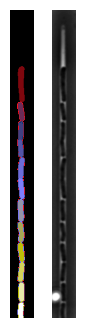

In [5]:
exp_dir = os.getcwd()
mask_dir = exp_dir + "/your_masks.zarr/"
# mask_dir = exp_dir + "/fluo_masks_wide_long.zarr/"
channel_image_dir = exp_dir + "/your_experiment_images.zarr/"

z1 = zarr.open(mask_dir, mode='r')
z2 = zarr.open(channel_image_dir, mode='r')
print(z1.shape)
print(z2.shape)
fig, ax=plt.subplots(1, 2, figsize=(1, 4))
trench = 10
timepoint = 594
channel = 0
ax[0].imshow(z1[trench, timepoint, channel, :, :], cmap='gist_stern')
ax[1].imshow(z2[trench, timepoint, channel, :, :], cmap='Greys_r')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Generate cell properties for tracking
 - `dt` is your time interval between frame in minutes
 - `min_size` is the minimal mask size to include in measuring properties
 - `channels` is a list of all channel index you want to measure
 - `c_names` is a list of all channel corresponding names
 - `step` is the timesteps to measure, if your time interval is small, increasing this will reduce error from segmentation
 - `descriptor` whether or not to use Zernike descriptors as one of the mask properties
 - `radius` used for evaluation Zernike moments, make sure this is larger than the average value of a cell

In [ ]:
generate_csv(mask_dir, channel_image_dir, exp_dir + "/prop/", 
             dt=1, min_size=200, channels=[0], c_names=['PC'], 
             step=1, descriptor=True, radius=100)

# or process the masks first

(640, 40)


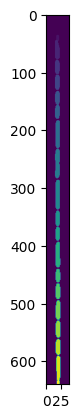

In [6]:
mask = z1[trench, timepoint, 1, :, :]
print(mask.shape)
pix_mic_conv = 0.10787/1.4

def correction(mask, min_size):
    mask = mask.astype(bool)
    # filtered = remove_small_objects(mask, min_size=min_size)

    width = int(mask.shape[1]*pix_mic_conv*2.5) # 2.5
    height = int(mask.shape[1]*pix_mic_conv)
    X, Y = np.ogrid[0:width*2+1, 0:height*2+1]

    footprint1 = (1./4 * (X - width)**2 + (Y - height)**2 < height**2).astype(np.uint8)
    # sep = erosion(filtered, footprint1)
    sep = erosion(mask, footprint1)
    labels = dilation(label(sep, connectivity=1), footprint1)
    filtered = remove_small_objects(labels, min_size=min_size)
    return labels

labels = correction(mask, 200)
plt.imshow(labels)

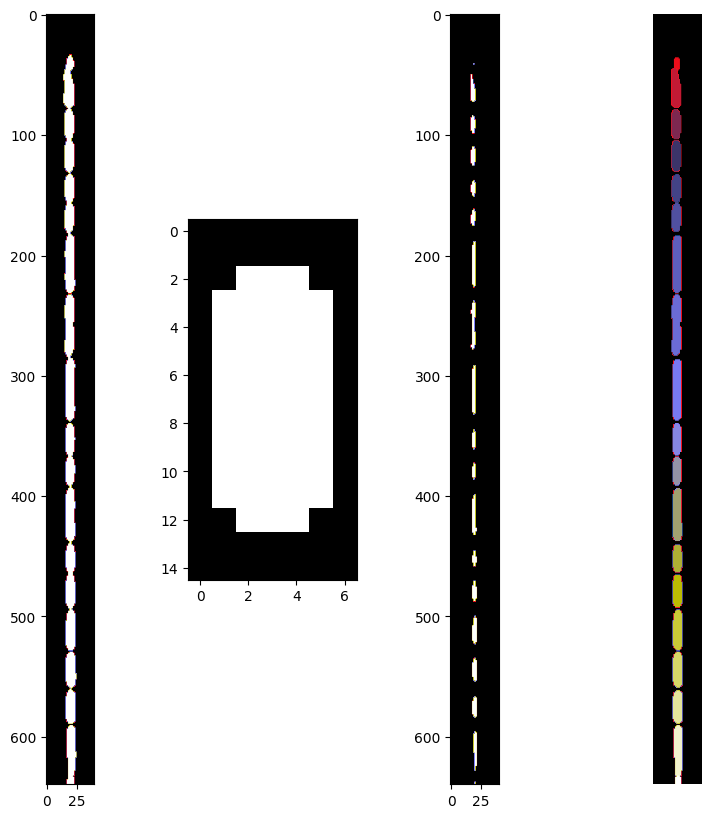

In [7]:
mask = mask.astype(bool)
filtered = remove_small_objects(mask, min_size=300)
# width = int(mask.shape[1]/10)
# height = int(mask.shape[1]/25)
width = int(mask.shape[1]*pix_mic_conv*2.5)
height = int(mask.shape[1]*pix_mic_conv)
X, Y = np.ogrid[0:width*2+1, 0:height*2+1]
footprint1 = (1./4 * (X - width)**2 + (Y - height)**2 < height**2).astype(np.uint8)
sep = erosion(filtered, footprint1)
labels = dilation(label(sep, connectivity=1), footprint1)

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(mask, cmap='gist_stern')
plt.subplot(1, 4, 2)
plt.imshow(footprint1, cmap='gist_stern')
plt.subplot(1, 4, 3)
plt.imshow(sep, cmap='gist_stern')
plt.subplot(1, 4, 4)
plt.imshow(labels, cmap='gist_stern')
plt.axis('off')
plt.show()

In [8]:
def pre_proc_seg_error(mask_path, save_path, min_size=0): 
    # use information from PC or fluo images?
    z1 = zarr.open(mask_path, mode='r')
    channel_num = 3
    z2_shape = z1.shape[:2] + (channel_num,) + z1.shape[3:]
    # z2 = zarr.open(save_path, mode='w', shape=z2_shape)
    z2 = zarr.zeros(z2_shape)
    # zarr.save(save_path, z2)
    # z3 = zarr.open(save_path, mode='w')
    print(z2.shape)
    # Parallel processing part
    def process_and_save(i, j, min_size=min_size):
        mask_image = z1[i, j, 1, :, :]
        corrected_image = correction(mask_image, min_size)
        z2[i, j, 1, :, :] = corrected_image
        
    all_indices = [(i, j) for i in range(z1.shape[0]) for j in range(z1.shape[1])]
    
    for i, j in tqdm(all_indices):
        process_and_save(i, j, min_size=min_size)
    # Parallel(n_jobs=5, require='sharedmem')(delayed(process_and_save)(i, j, min_size=min_size)
    #                                         for i, j in tqdm(all_indices, desc="Processing images"))
    # , require='sharedmem'
    zarr.save(save_path, z2)
    return f"saved to {save_path}"

In [41]:
pre_proc_seg_error(mask_dir,
                   exp_dir + "/masks_processed.zarr/", 
                   min_size=80)

(111, 721, 3, 640, 40)


100%|██████████████████████████████████████| 80031/80031 [1:05:41<00:00, 20.31it/s]


'saved to /home/rl627/SSD1/20231207_Cm_SB13/pc_masks_wide_long_proc_3.zarr/'

In [9]:
post_mask_dir = exp_dir + "/masks_processed.zarr/"

In [11]:
generate_csv(post_mask_dir, channel_image_dir, exp_dir + "/prop_3min/", 
             1, 80, [0, 1, 2], ['CFP', 'PC', 'mVenus'], 
             step=3, descriptor=True, radius=100)

reading through images in channel PC...: 100%|███| 111/111 [20:33<00:00, 11.11s/it]
reading through images in channel mVenus...: 100%|█| 111/111 [13:28<00:00,  7.28s/i


"saved to ['/home/rl627/SSD1/20231207_Cm_SB13/prop_3min/CFP_properties.csv', '/home/rl627/SSD1/20231207_Cm_SB13/prop_3min/PC_properties.csv', '/home/rl627/SSD1/20231207_Cm_SB13/prop_3min/mVenus_properties.csv']"